# Example CV3 - Classification with a squeezing feature map

In this example we implement the squeezing feature map together with the "implicit classifier" inspired by [Schuld and Killoran (2018)](https://arxiv.org/abs/1803.07128). To make the simulation run in reasonable time, we use a low squeezing amplitude and low truncation of the Hilbert space (i.e., `cutoff_dim` of the `fock` backend) for the didactic task of classifying a linearly separable, 2-dimensional binary dataset. 

This example also demonstrates how in CV simulations with a truncated Hilbert space, one can use a dummy circuit with the identity expectation in order to keep track of the trace of the quantum state. Using too low truncations can cause the trace to be lower than one, which means that the simulation is not accurate.

### Imports

We import PennyLane, the wrapped version of NumPy provided by PennyLane, as well as an optimizer. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdagradOptimizer

The device is the Strawberry Fields simulator with two quantum modes or "wires". You need to have the Strawberry Fields plugin for PennyLane installed.

In [2]:
try:
    dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=10)
except:
    print("To run this demo you need to install the strawberryfields plugin...")

### Quantum node

The variational circuit which defines the quantum node consists of two parts. First, the input is "encoded into Hilbert space" by a squeezing feature map.

In [3]:
def featuremap(x):
    qml.Squeezing(0.6, x[0], wires=0)
    qml.Squeezing(0.6, x[1], wires=1)

Next, a layered circuit serves as a trainable linear classifier in Hilbert space. A single layer is defined as:

In [4]:
def layer(v):

    qml.Beamsplitter(v[0], v[1], wires=[0, 1])

    # linear gates in quadrature representation
    qml.Displacement(v[2], 0., wires=0)
    qml.Displacement(v[3], 0., wires=1)

    # quadratic gates in quadrature representation
    qml.QuadraticPhase(v[4], wires=0)
    qml.QuadraticPhase(v[5], wires=1)

    # cubic gates in quadrature representation
    qml.CubicPhase(v[6], wires=0)
    qml.CubicPhase(v[7], wires=1)

We use two variational circuits encapsulated within quantum nodes. Both first encode the input via the feature map and then execute the layers of the classifier. The first quantum node returns the expectation of measuring 2 photons in mode 0 and 0 photons in mode 1 (Fock state |2,0>); the second quantum node returns the expectation of Fock state |0,2>.

In [5]:
@qml.qnode(dev)
def circuit1(var, x=None):
    featuremap(x)
    for v in var:
        layer(v)
    return qml.expval.NumberState(np.array([2, 0]), wires=[0, 1])


@qml.qnode(dev)
def circuit2(var, x=None):
    featuremap(x)
    for v in var:
        layer(v)
    return qml.expval.NumberState(np.array([0, 2]), wires=[0, 1])

The quantum classifier executes these circuits and computes the renormalized probability of measuring Fock state  |2,0> instead of |0,2>.

In [6]:
def qclassifier(var, x=None):
    p1 = circuit1(var, x=x)
    p2 = circuit2(var, x=x)
    return p1 / (p1 + p2)

We construct one more 'virtual' circuit which is useful for simulations with the `strawberryfields.fock` backend. It applies the feature map and layers as in `circuit1` and `circuit2`, but measures the identity operator. Effectively, this returns the trace of the final state before measurement. 

In [7]:
@qml.qnode(dev)
def trace(var, x=None):
    featuremap(x)
    for v in var:
        layer(v)
    return qml.expval.Identity([0, 1])

### Objective

In the cost function we obtain the outputs from the variational circuit, and compute the square loss compared with the target labels `Y`. Here we use Penny Lane's numpy library for the square loss.

We also add an L2 regularization to the cost, penalizing when the norm of the weight vector gets large. This is not only useful for generalization, but also to keep parameters in the regime where the fock backend is accurate.

In [8]:
def cost(var, X, Y):
    outpts = np.array([qclassifier(var, x=x) for x in X])
    squareloss = np.mean((Y - outpts) ** 2)
    l2regularization = np.sum(np.inner(var, var))
    return squareloss + 0.001 * l2regularization

### Optimization

We set the seed to make the random operations deterministic and reproducable.

In [9]:
np.random.seed(0)

We load data samples from the moons dataset and split it into a training and validation set.

In [10]:
# load function data
data = np.loadtxt("data/blobs.txt")
X = data[:, 0:2]
Y = data[:, 2]

# split into training and validation set
num_data = len(Y)
num_train = int(0.5 * num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[: num_train]]
Y_train = Y[index[: num_train]]
X_val = X[index[num_train: ]]
Y_val = Y[index[num_train: ]]

Before we train a model, let's take an initial look at the data.

*Note: For the next cell to work you need the matplotlib library.* 

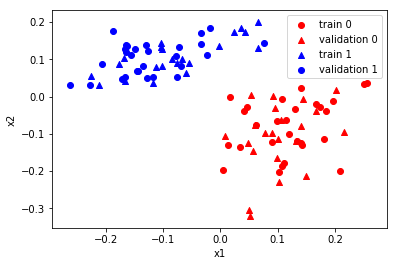

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure()
plt.scatter(X_train[:,0][Y_train==0], X_train[:,1][Y_train==0], marker='o', color='red', label='train 0')
plt.scatter(X_val[:,0][Y_val==0], X_val[:,1][Y_val==0], marker='^', color='red', label='validation 0')
plt.scatter(X_train[:,0][Y_train==1], X_train[:,1][Y_train==1], marker='^', color='blue', label='train 1')
plt.scatter(X_val[:,0][Y_val==1], X_val[:,1][Y_val==1], marker='o', color='blue', label='validation 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

The trainable circuit parameters (called variables internally in PennyLane) are initialized with values sampled from a normal distribution. We use 4 layers.

In [12]:
num_layers = 4
var_init = 0.1 * np.random.randn(num_layers, 8)

var_init

array([[ 0.04253934, -0.00279712,  0.14759898,  0.06467801, -0.03643343,
        -0.06787774, -0.03536279, -0.07407475],
       [-0.06750218, -0.01327843,  0.06198011,  0.17911685,  0.01710004,
        -0.17256714,  0.01606585, -0.08589853],
       [-0.02064209,  0.04884265, -0.0838331 ,  0.03811637, -0.09909033,
         0.101788  ,  0.03415874, -0.12508862],
       [ 0.09252508, -0.09047862,  0.18436915,  0.15255072, -0.14455356,
         0.03771606, -0.00705572,  0.06041597]])

We choose the Adam optimizer and update the weights for 150 steps with a batch size of 5. Every 5 steps the accuracy is computed for the entire training set. You will find that by changing the random seed, training may converge faster or slower.

*You may see fluctuations in the training stemming from stochastic gradient descent, which uses only a few data points in every update, as well as the choice of the learning rate. Sometimes, the cost decreases but the accuracy does not. Play around with the hyperparameters to investigate the convergence behavious. For example, choose a smaller stepsize to make training smoother - but at the price of converging slower. *

In [13]:
# create optimizer
opt = AdagradOptimizer(stepsize=0.02)

# train
batch_size = 5
var = var_init

for it in range(150):

    # select minibatch of training samples
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]

    var = opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), var)

    if it % 10 == 0:
        # Print current cost, and compute accuracy on train and validation set
        pred_train = [np.round(qclassifier(var, x=x_)) for x_ in X_train]
        pred_val = [np.round(qclassifier(var, x=x_)) for x_ in X_val]
        acc_train = np.mean(Y_train == pred_train)
        acc_val = np.mean(Y_val == pred_val)
        current_trace = trace(var, x=X_train[0])
        print("Iter: {:5d} | Cost: {:0.7f} | Accuracy train/validation: {:0.2f}/{:0.2f} | Trace: {:0.5f}"
              .format(it + 1, cost(var, X_train, Y_train), acc_train, acc_val, current_trace))
    else:
        # Only print the current cost
        print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X_train, Y_train)))

Iter:     1 | Cost: 0.2985429 | Accuracy train/validation: 0.56/0.44 | Trace: 0.99799
Iter:     2 | Cost: 0.2696698 
Iter:     3 | Cost: 0.2689670 
Iter:     4 | Cost: 0.2474093 
Iter:     5 | Cost: 0.2351956 
Iter:     6 | Cost: 0.2516888 
Iter:     7 | Cost: 0.2178556 
Iter:     8 | Cost: 0.2947281 
Iter:     9 | Cost: 0.2339875 
Iter:    10 | Cost: 0.2089900 
Iter:    11 | Cost: 0.2242606 | Accuracy train/validation: 0.56/0.60 | Trace: 0.99806
Iter:    12 | Cost: 0.2091815 
Iter:    13 | Cost: 0.2272281 
Iter:    14 | Cost: 0.2222120 
Iter:    15 | Cost: 0.1987857 
Iter:    16 | Cost: 0.1968113 
Iter:    17 | Cost: 0.1962748 
Iter:    18 | Cost: 0.2039026 
Iter:    19 | Cost: 0.1961442 
Iter:    20 | Cost: 0.1913501 
Iter:    21 | Cost: 0.1884649 | Accuracy train/validation: 0.90/0.98 | Trace: 0.99803
Iter:    22 | Cost: 0.1901138 
Iter:    23 | Cost: 0.1860582 
Iter:    24 | Cost: 0.1890875 
Iter:    25 | Cost: 0.2159293 
Iter:    26 | Cost: 0.2010807 
Iter:    27 | Cost: 0.1840501

With the last predictions we can plot the classification of the model for the data. You will get better results for more complex datasets when using a higher squeezing amplitude, but at the price of making the simulation more expensive by increasing the truncation or "cutoff_dim" of the simulator.

Tipp: By rerunning the previous cell (possibly with a different number of iterations in `for it in range(150):`), you can train the model further, using the already optimized parameters stored in the variable `var`.

*For the following cell you need to have imported matplotlib's pyplot above.*

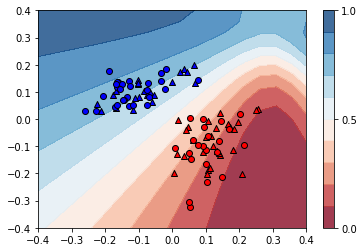

In [14]:
# make data for plot
xx, yy = np.meshgrid(np.linspace(-0.4, 0.5, 20), np.linspace(-0.4, 0.4, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# start plot
plt.figure()
cm = plt.cm.RdBu

# plot decision regions
predictions_grid = [qclassifier(var, x=x) for x in X_grid]
Z = np.reshape(predictions_grid, xx.shape)
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0., 1.1, 0.1), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])

# plot data
plt.scatter(X_train[:, 0][Y_train==0], X_train[:, 1][Y_train==0], c='r', marker='^', edgecolors='k')
plt.scatter(X_train[:, 0][Y_train==1], X_train[:, 1][Y_train==1], c='b', marker='^', edgecolors='k')
plt.scatter(X_val[:, 0][Y_val==0], X_val[:, 1][Y_val==0], c='r', marker='o', edgecolors='k')
plt.scatter(X_val[:, 0][Y_val==1], X_val[:, 1][Y_val==1], c='b', marker='o', edgecolors='k')

plt.ylim(-0.4, 0.4)
plt.xlim(-0.4, 0.4)
plt.show()